# Water flux within the root - Numerical solutions in Pyhton

by Daniel Leitner, Andrea Schnepf

In the following we will first describe the derivation of the numerical method (based on Schnepf et al. ), the resulting Python code (available as single file at the CRootBox git repository), and finally we demonstrate Benchmark 1 and 2.

## Numerical derivation

In the graph the pressure $p_i$ is defined for each node $n_i$.  The edges at node $n_i$ are denoted as $e_{ij}$ with $j \in N(i)$, where $N(i)$ are the indices of the neighbouring nodes.  Thus, the edge $e_{ij}$ connects node $n_i$ and node $n_j$ for each $j \in N(i)$. \\

For each edge $e_{ij}$ the axial water flux from $n_i$ to $n_j$ is 
\begin{eqnarray}
q_{z,ij} = - k_z ( \frac{p_j-p_i}{l_{ij}} +\rho g v_{ij,3} ),
\end{eqnarray}
and the radial flux from segment $e_{ij}$ into the soil is 
\begin{eqnarray}
q_{r,ij} = - 2 a_{ij} \pi l_{ij} k_r (p_s - p_{ij}), 
\end{eqnarray}
where $l_{ij}$ is the length, $v_{ij}$ the normed direction, $a_{ij}$ the radius, $p_{ij}$ is the mean edge pressure ($p_{ij} = \frac{p_i+p_j}{2}$) of the edge $e_{ij}$. 
The value $p_s$ is the soil potential, surrounding the edge $e_{ij}$. 
The, net flux of a node is the sum of all axial fluxes $q_{z,ij}$ and half of the radial fluxes $q_{r,ij}$:
\begin{eqnarray}
q_{ij} &=&  - a_{ij} \pi l_{ij} k_r p_s - k_z \rho g v_{ij,3}  \nonumber \\ 
& & \frac 1 2 a_{ij} \pi l_{ij} k_r p_i + \frac{1}{l_{ij}} k_z p_i  \nonumber \\
& & \frac 1 2 a_{ij} \pi l_{ij} k_r p_j - \frac{1}{l_{ij}} k_z  p_j.   \label{netflux}
\end{eqnarray} \\

The first Kirchhoff law states that all fluxes into each node cancel out. This can be presented as a linear equation  
\begin{eqnarray}
\left( C p \right)_i =  \sum_{j \in N(i)} c_{ii} p_i + c_{ij} p_j = b_i, \label{linearsystem}
\end{eqnarray}
where each row $i$ of $C$ represents the linear equation for node $i$. 
The diagonal elements of $C$ are derived by the second line of Eqn (\ref{netflux}):
\begin{eqnarray}
c_{ii} := \sum_{j \in N(i)} \frac 1 2 a_{ij} \pi l_{ij} k_r + \frac{1}{l_{ij}} k_z, 
\end{eqnarray}
with $c_{ii}=c_{jj}$, and the other entries by the third line of Eqn (\ref{netflux}):
\begin{eqnarray}
c_{ij} := \sum_{j \in N(i)} \frac 1 2  a_{ij} \pi l_{ij} k_r - \frac{1}{l_{ij}} k_z, 
\end{eqnarray}
with $c_{ij}=c_{ji}$. 
The value $b_i$ is derived from first line of Eqn (\ref{netflux}): 
\begin{eqnarray}
b_i := \sum_{j \in N(i)} a_{ij} \pi l_{ij} k_r p_s + k_z \rho g v_{ij,3},
\end{eqnarray}
and 
\begin{eqnarray}
b_j := \sum_{j \in N(i)} a_{ij} \pi l_{ij} k_r p_s - k_z \rho g v_{ij,3},
\end{eqnarray}
because $v_{ij,3} = - v_{ji,3}$. This yields the linear system $Cp = b$ of Eqn (\ref{linearsystem}). \\

Note that $C$ is symmetric (since the graph is undirected) and sparse (most $c_{ij}$ are zero, since all $c_{ij}$ are zero where node $i$ and node$j$ are not connected by an edge). 
The soil matric potential $p_s$ and the direction of the edges $v_{ij}$ only enter the equation on the rhs affecting $b_i$.

### Dirichlet

The simplest way to implement a fixed pressure at node i, is to replace row i in the matrix $C$ by $e_i^T$, and $b_i$ by the desired matric potential. In this way the equation for node i of the linear equation $C p = b$ reads $p_i = h_i$.	

### Neumann

Neumann boundary condition is implemented, by adding the flux $f_i$ to the specific node $i$ by adding it to the right hand side (i.e. $b_i := b_i + f_i$) of the linear equation.

## Implementation in Python 

We start wtih some imports:

In [1]:
from math import *
import numpy as np
from numpy.linalg.linalg import norm
import matplotlib.pylab as plt
from scipy import sparse
import scipy.sparse.linalg as LA

### Creating the linear system 

The following code builds the linear system as described above. Therefore we loop over each segment $e_{ij}$, and add its share to the system (i.e. $c_{ii}, c_{ij}, c_{jj}, c_{ji}, b_{i}, b_{j}$)

The inputs are all parameters that are needed: 
* `seg`: numpy array ($N_s$,2) of segment indices [1]
* `nodes`: numpy array ($N$,3) of the node coordinates [L]
* `radius`: segment radii [L]
* `kr` radial conductivity for each segment [L2 T M−1]
* `kz` axial conductivity for each segment [L5 T M-1]
* `rho` density of soil water [M L-3]
* `g` gravitational acceleration [L T−2]
* `soil_p` lambda function returning the soil matric potential at a given location, p=soil_p(x,y,z) [M L−1 T−2]
 
The output is the linear system $Qx=b$

In [2]:
def linear_system(seg, nodes, radius, kr, kz, rho, g, soil_p):
    
    Ns = seg.shape[0]
    N = nodes.shape[0]
    I = np.zeros(4*Ns)
    J = np.zeros(4*Ns)    
    V = np.zeros(4*Ns)
    b = np.zeros(N)    
    
    k = 0     
    for c in range(0,Ns):        
        
        i = seg[c,0]
        j = seg[c,1]        
        n1 = nodes[i,:]
        n2 = nodes[j,:]       
        mid = 0.5*(n1+n2)        
        p_s = soil_p(mid[0],mid[1],mid[2]) # evaluate soil matric potential
        v = n2-n1
        l = norm(v)        
        vz = v[2] / l # normed direction                
        a = radius[c]
        
        cii = a*pi*l*kr[c]/2 + kz[c]/l # Eqn (5)
        cij = a*pi*l*kr[c]/2 - kz[c]/l # Eqn (6)
        bi = a*pi*l*kr[c]*p_s # first term of Eqn (7) & (8)            
        
        # edge ij
        b[i] +=  ( bi + kz[c]*rho*g*vz )  # Eqn (7)             
        I[k] = i
        J[k] = i     
        V[k] += cii
        k += 1                        
        I[k] = i
        J[k] = j        
        V[k] += cij
        k += 1 
        
        # edge ji
        i, j = j, i
        b[i] += ( bi - kz[c]*rho*g*vz ) # Eqn (8) 
        I[k] = i
        J[k] = i  
        V[k] += cii    
        k += 1                          
        I[k] = i
        J[k] = j        
        V[k] += cij        
        k += 1 
         
    Q = sparse.coo_matrix((V,(I,J)))    
    Q = sparse.csr_matrix(Q)     
    return (Q, b)

Modifies the linear system $Q, b$ to describe Diriclet boundary conditions at the node indices `n0` as described above.

Input parameter are 
* `n0`: node indices where to apply the boundary condition
* `d`: fixed potential at n0

In [3]:
def bc_dirichlet(Q, b, n0, d):
    c = 0
    for c in range(0, len(n0)):
        i = n0[c]          
        e0 = np.zeros((1,Q.shape[1])) # build zero vector
        Q[i,:] = sparse.csr_matrix(e0) # replace row i with ei
        Q[i,i] = 1
        b[i] = d[c]    
    return Q, b 

Modifies the linear system $Q, b$ to describe a Neumann boundary conditions at the node indices `n0` as described above.

Input parameter are 
* `n0`: node indices where to apply the boundary condition
* `f`: flux at n0

In [4]:
def bc_neumann(Q, b, n0, f):
    c = 0
    for c in range(0, len(n0)):                
        i = n0[c]  # print("Neumann BC at node "+str(i))       
        b[i] += f[c]        
    return Q, b 

## Benchmark 1 

We compare the Pyhton numerical implementation to the analytical solution. First, some additional definitions

In [5]:
g = 9.81                 # gravitational acceleration (m/s^2)   
rho = 1.e3               # density of water, (kg/m^3)      
ref = 1.e5               # reference pressure (kg/ (m s^2))

def toPa(ph): # cm pressure head to Pascal (kg/ (m s^2))
    return ref + ph / 100. * rho * g

def toHead(pa): # Pascal (kg/ (m s^2)) to cm pressure head
    return (pa-ref) * 100. / rho / g

Next we pick the parameters 

In [6]:
# Parameters
L = 0.5                # length of single straight root (m)
a = 2.e-3              # radius (m)
kz = 5.e-13            # axial conductivity (m^5 s / kg) (mal rho ergibt die alten einheiten)
kr = 2.e-9             # radial conductivity per root type (m^2 s / kg) 
p_s = toPa(-200)       # static soil pressure (cm) 
p0 = toPa(-1000)       # dircichlet bc at top

First we recalculate the analytical solution (for later comparison)

In [7]:
# Analytical solution
c = 2*a*pi*kr/kz
p_r = lambda z: toHead( p_s + d[0]*exp(sqrt(c)*z) + d[1]*exp(-sqrt(c)*z) )
# Boundary conditions
AA = np.array([[1,1], [sqrt(c)*exp(-sqrt(c)*L), -sqrt(c)*exp(sqrt(c)*L)] ]) # dirichlet top, neumann bot
bb = np.array([p0-p_s, -rho*g]) #
d = np.linalg.solve(AA, bb) # compute constants d_1 and d_2 from bc
# Evaluate function
za_ = np.linspace(0,-L,100)
pr = list(map(p_r, za_))

For the numerical solution we first create a grid. nnz denotes the resolution.

In [8]:
nnz = 100
nodes = np.zeros((nnz,3))
seg = np.zeros(((nnz-1),2), dtype=int) 
c = 0
for i in range(1, nnz):
    seg[c,0] = i-1
    seg[c,1] = i
    c += 1    
    nodes[i,:] = [0.,0.,-i*L/(nnz-1)]

Next we copy the constant values to lists, so that we have a value per segment, and create a call back function for the soil matric potential.

In [9]:
kr_ = [kr] * (nnz-1)
kz_ = [kz] * (nnz-1)
a_ = [a] * (nnz-1)            
soil = lambda x,y,z : p_s # call back function for soil potential

Now we create the linear system, and apply the boundary conditions

In [10]:
Q, b = linear_system(seg, nodes, a_, kr_, kz_, rho, g, soil) #  

Q, b = bc_dirichlet(Q, b, np.array([0]), np.array([p0])) # dirichlet top
Q, b = bc_neumann(Q, b, [nnz-1], [0]) # neumann bot

x = LA.spsolve(Q, b, use_umfpack = True) # direct

And, the result:

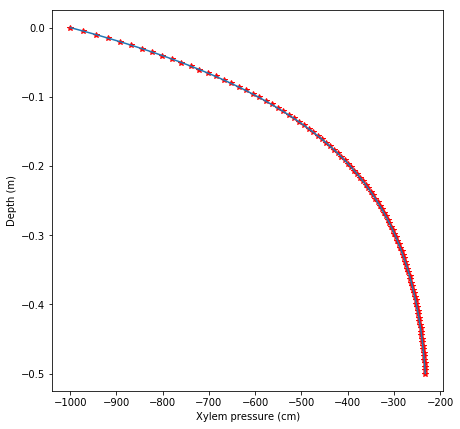

In [11]:
fig=plt.figure(figsize=(7, 7))
plt.plot(list(map(toHead, x)),za_,"r*")
plt.plot(pr,za_)
plt.xlabel("Xylem pressure (cm)")
plt.ylabel("Depth (m)")
# for automatic evalutation
np.savetxt("xylem_flux/b1/python", np.vstack((za_,list(map(toHead, x)))),delimiter=',')
plt.show()

## Benchmark 2


The benchmark is given by a static small root system, static conductivities, a predefined pressure (-1000 cm) at the root collar, and no-flux at the root tips.

In [22]:
nodes = np.array([ [0.00,0.00,-3.00], [-0.00,-0.01,-3.48], [-0.85,0.48,-3.71], [-1.69,0.99,-3.90], [-2.58,1.32,-4.21], [-3.48,1.67,-4.49], [-4.38,2.00,-4.77], [-5.24,2.40,-5.09], [-6.08,2.82,-5.42], [-6.93,3.27,-5.69], [-6.96,3.29,-5.70], [-0.00,0.01,-3.97], [0.20,-0.95,-4.20], [0.43,-1.88,-4.49], [0.65,-2.81,-4.77], [0.84,-3.75,-5.06], [1.04,-4.70,-5.31], [1.27,-5.64,-5.54], [1.43,-6.58,-5.84], [1.48,-6.91,-5.94], [-0.01,0.03,-4.45], [0.75,0.68,-4.48], [1.52,1.32,-4.50], [2.30,1.94,-4.46], [3.07,2.58,-4.41], [3.88,3.16,-4.46], [4.73,3.69,-4.50], [5.34,4.05,-4.53], [-0.03,0.06,-4.97], [-0.73,0.63,-5.40], [-1.46,1.20,-5.79], [-2.15,1.80,-6.18], [-2.76,2.48,-6.59], [-3.16,3.16,-7.21], [-3.63,3.90,-7.64], [-0.06,0.07,-5.42], [0.07,1.04,-5.61], [0.23,2.00,-5.82], [0.46,2.93,-6.11], [0.72,3.85,-6.40], [0.99,4.77,-6.69], [1.06,5.11,-6.78], [-0.10,0.08,-5.96], [0.35,0.90,-6.31], [0.80,1.72,-6.65], [1.23,2.55,-7.01], [1.62,3.41,-7.34], [1.70,3.58,-7.41], [-0.14,0.10,-6.46], [0.05,-0.81,-6.83], [0.29,-1.72,-7.18], [0.43,-2.62,-7.59], [0.50,-3.12,-7.84], [-0.19,0.12,-7.02], [0.32,0.98,-7.03], [0.82,1.84,-6.95], [1.07,2.23,-6.88], [-0.23,0.17,-7.56], [0.68,-0.18,-7.80], [1.12,-0.35,-7.93], [-0.24,0.21,-8.14], [-0.01,0.36,-8.22], [-0.25,0.24,-8.69], [-0.24,0.25,-9.25], [-0.24,0.26,-9.71], [-0.26,0.26,-10.09], [-0.28,0.25,-10.57], [-0.26,0.24,-11.05], [-0.26,0.21,-11.58], [-0.25,0.19,-12.06], [-0.25,0.17,-12.55], [-0.23,0.15,-13.00], [-0.23,0.12,-13.46], [-0.22,0.12,-13.99], [-0.21,0.15,-14.54], [-0.19,0.20,-15.07], [-0.17,0.24,-15.60], [-0.17,0.31,-16.17], [-0.15,0.36,-16.64], [-0.12,0.43,-17.18], [-0.11,0.48,-17.70], [-0.07,0.52,-18.23], [-0.06,0.53,-18.53] ])
seg = np.array([ [0,1], [1,11], [11,20], [20,28], [28,35], [35,42], [42,48], [48,53], [53,57], [57,60], [60,62], [62,63], [63,64], [64,65], [65,66], [66,67], [67,68], [68,69], [69,70], [70,71], [71,72], [72,73], [73,74], [74,75], [75,76], [76,77], [77,78], [78,79], [79,80], [80,81], [81,82], [1,2], [2,3], [3,4], [4,5], [5,6], [6,7], [7,8], [8,9], [9,10], [11,12], [12,13], [13,14], [14,15], [15,16], [16,17], [17,18], [18,19], [20,21], [21,22], [22,23], [23,24], [24,25], [25,26], [26,27], [28,29], [29,30], [30,31], [31,32], [32,33], [33,34], [35,36], [36,37], [37,38], [38,39], [39,40], [40,41], [42,43], [43,44], [44,45], [45,46], [46,47], [48,49], [49,50], [50,51], [51,52], [53,54], [54,55], [55,56], [57,58], [58,59], [60,61] ])
age = np.array([ 8.00,7.76,7.52,7.29,7.03,6.80,6.53,6.28,6.00,5.73,5.43,5.16,4.87,4.64,4.44,4.20,3.95,3.68,3.43,3.17,2.94,2.70,2.42,2.14,1.85,1.57,1.27,1.02,0.73,0.45,0.16,-0.00,2.29,2.02,1.74,1.43,1.11,0.77,0.41,0.01,0.00,2.04,1.77,1.48,1.18,0.85,0.51,0.14,0.00,1.78,1.51,1.22,0.92,0.60,0.26,0.00,1.51,1.24,0.96,0.66,0.34,0.00,1.28,1.01,0.73,0.43,0.12,0.00,0.97,0.69,0.39,0.07,0.00,0.72,0.45,0.17,0.00,0.41,0.14,0.00,0.13,0.00,0.00 ])
types = np.array([ 1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2 ])
a_tap = 0.2 # tap root radius (cm)
a_lateral = 0.1 # lateral root radius (cm)
kz = lambda age: 1.e-18 # m^4 / (Pa s)
kr = lambda age:  0.2e-13  # m / (Pa s)

We prepare the parameters to use the aboves numerical scheme, and create the linear system:

In [23]:
# Parameter
aa = lambda t: 1.e-2*(a_tap*(t==1)+a_lateral*(t==2)) # cm->m 
a_ = list(map(aa, types)) 
sage = age[seg[:,1]] # age per segment
kr_ =  list(map(kr, sage)) # m / (Pa s)
kz_ = list(map(kz, sage)) # m^4 / (Pa s)
p_s = toPa(-200) # cm->Pa
soil = lambda x,y,z : p_s # cm pressure head
rho = 1.e3 # kg/m^3
g = 9.81 # m/s^2 
rs_nodes = np.array(nodes)*1.e-2 # cm->m, and convert from list to numpy array
rs_seg = np.array(seg) # convert from list to numpy array 
    
#  Create linear system
Q, b = linear_system(rs_seg, rs_nodes, a_, kr_, kz_, rho, g, soil) 

Next, we need to set the boundary conditions by modifying the linear system:

In [24]:
tips = [10,19,27,34,41,47,52,56,59,61,82] # are precomputed in description of Benchmark 2 
p0 = toPa(-1000) # cm->Pa, pressure at root collar 

Q, b = bc_dirichlet(Q, b, np.array([0]), np.array([p0])) # dirichlet top
Q, b = bc_neumann(Q, b, np.array(tips), np.zeros(len(tips))) # neumann at tips

Finally, we can solve the system

In [25]:
x = LA.spsolve(Q, b, use_umfpack = True) # direct
x = toHead(x)

qz = -kz1*((x[1]-x[0])/0.001-rho*g) *24*3600*1e9 # m^3 s^-1 -> mm^3 day^-1 
qr = -0.001*2*pi*a_tap*1.e-2*kr1*(p_s-x[0]) *24*3600*1e9 # m^3 s^-1 -> mm^3 day^-1 
print("net collar flux is", qr+qz, "mm^3/day; ", "axial", qz, ", radial", qr) 

net collar flux is -12.8566752098 mm^3/day;  axial -11.089533866 , radial -1.76714134375


and plot the final result:

from  -1000.0 to -267.682597921  cm pressure head


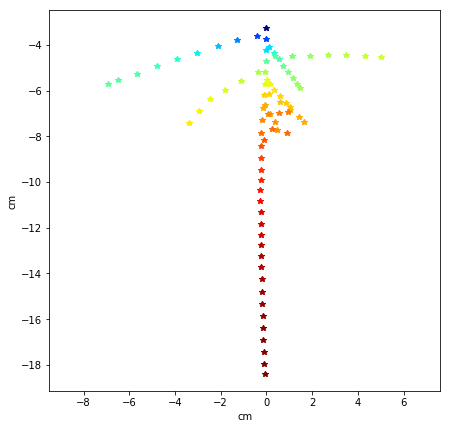

In [26]:
xmin = min(x)
xmax = max(x)
print("from ", xmin, "to", xmax, " cm pressure head")
# Plot
nodes_ = np.array(nodes)
fig=plt.figure(figsize=(7, 7))
y_ = []
x_ = []
for i,s in enumerate(seg): 
    n = 0.5*(nodes_[s[0]]+nodes_[s[1]]) # mid point
    c = (x[s[0]]-xmin)/(xmax-xmin)
    plt.plot([n[0], n[0]], [n[2], n[2]], "*", color = plt.cm.jet(c))    
    y_.append(n[2]/100)
    x_.append(x[s[0]])
plt.axis('equal')
plt.xlabel("cm")
plt.ylabel("cm")
plt.show()
# Save file
np.savetxt("xylem_flux/b2/python", np.vstack((y_,x_)),delimiter=',')

## Benchmark 3


Same as before but with age depending conductivities:

In [31]:
kz0, kz1 = 0.5e-19, 1.e-18 # m^4 / (Pa s)
kr0, kr1 = 1.7e-13, 0.2e-13 # m / (Pa s)
kz = lambda age: kz0*(age<=3)+kz1*(age>3)
kr = lambda age: kr0*(age<=3)+kr1*(age>3)
kr_ =  list(map(kr, sage)) # m / (Pa s)
kz_ = list(map(kz, sage)) # m^4 / (Pa s)

#  Create linear system
Q, b = linear_system(rs_seg, rs_nodes, a_, kr_, kz_, rho, g, soil) 

# BC
tips = [10,19,27,34,41,47,52,56,59,61,82] # are precomputed in description of Benchmark 2 
p0 = toPa(-1000) # cm->Pa, pressure at root collar 
Q, b = bc_dirichlet(Q, b, np.array([0]), np.array([p0])) # dirichlet top
Q, b = bc_neumann(Q, b, np.array(tips), np.zeros(len(tips))) # neumann at tips

x = LA.spsolve(Q, b, use_umfpack = True) # direct
x = toHead(x)

qz = -kz1*((x[1]-x[0])/0.001-rho*g) *24*3600*1e9 # m^3 s^-1 -> mm^3 day^-1 
qr = -0.001*2*pi*a_tap*1.e-2*kr1*(p_s-x[0]) *24*3600*1e9 # m^3 s^-1 -> mm^3 day^-1 
print("net collar flux is", qr+qz, "mm^3/day; ", "axial", qz, ", radial", qr) 

net collar flux is -8.84114326938 mm^3/day;  axial -7.07400192563 , radial -1.76714134375


from  -1000.0 to -199.51792948  cm pressure head


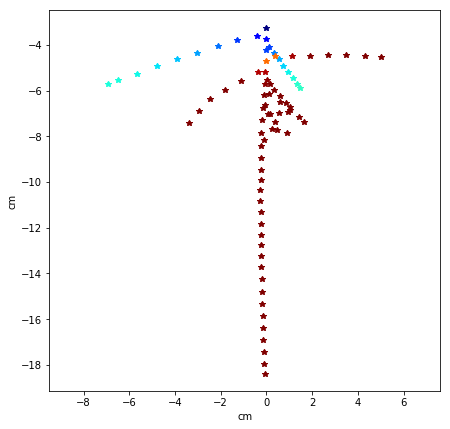

In [33]:
xmin = min(x)
xmax = max(x)
print("from ", xmin, "to", xmax, " cm pressure head")
# Plot
nodes_ = np.array(nodes)
fig=plt.figure(figsize=(7, 7))
y_ = []
x_ = []
for i,s in enumerate(seg): 
    n = 0.5*(nodes_[s[0]]+nodes_[s[1]]) # mid point
    c = (x[s[0]]-xmin)/(xmax-xmin)
    plt.plot([n[0], n[0]], [n[2], n[2]], "*", color = plt.cm.jet(c))    
    y_.append(n[2]/100)
    x_.append(x[s[0]])
plt.axis('equal')
plt.xlabel("cm")
plt.ylabel("cm")
plt.show()
# Save file
np.savetxt("xylem_flux/b3/python", np.vstack((y_,x_)),delimiter=',')

## References

Schnepf, A., Leitner, D., Landl, M., Lobet, G., Mai, T.H., Morandage S., Sheng, C., Zoerner, M., Vanderborght, J., Vereecken, H. (2018) CRootBox: a structural-functional modelling framework for root systems. *Annals of Botany*, 121 (5), 1033-1053
